In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np

In [2]:
class Transformer(nn.Module):
    def __init__(
        self,
        num_tokens,          # total vocabulary size (number of tokens)
        dim_model,           # dimension of embeddings / hidden size
        num_heads,           # number of attention heads
        num_encoder_layers,  # number of transformer encoder layers
        num_decoder_layers,  # number of transformer decoder layers
        dropout_p,           # dropout probability
    ):
        super().__init__()

        # ⚡ Core Transformer module: contains both encoder and decoder
        self.transformer = nn.Transformer(
            d_model=dim_model,                 # hidden dimension size
            nhead=num_heads,                   # multi-head attention heads
            num_encoder_layers=num_encoder_layers,  # encoder stack depth
            num_decoder_layers=num_decoder_layers,  # decoder stack depth
            dropout=dropout_p,                 # dropout for regularization
        )

    def forward(self):
        # ⚡ Forward function will define how inputs (src, tgt, masks) 
        #    are passed through the transformer. Currently not implemented.
        pass


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # 📘 Modified from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len → maximum sequence length (how far positional info extends)
        
        # 🔹 Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_p)
        
        # 🔹 Initialize a (max_len × dim_model) matrix for position encodings
        pos_encoding = torch.zeros(max_len, dim_model)

        # Positions: 0, 1, 2, ..., max_len-1 shaped as a column vector
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1)

        # Division term for scaling positions → 10000^(2i/dim_model)
        division_term = torch.exp(
            torch.arange(0, dim_model, 2).float() * (-math.log(10000.0) / dim_model)
        )
        
        # 🔹 Apply sine to even indices (2i)
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # 🔹 Apply cosine to odd indices (2i+1)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Reshape → (max_len, 1, dim_model), ready to be added to embeddings
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)

        # Register as buffer (stored in model, but not a trainable parameter)
        self.register_buffer("pos_encoding", pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        """
        token_embedding: shape (seq_len, batch_size, dim_model)
        returns: embedding + positional encoding (with dropout)
        """
        # Add positional encoding to embeddings (residual connection style)
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])


In [4]:
class Transformer(nn.Module):
    """
    Transformer model using PyTorch's nn.Transformer().
    Reference: Daniel Melchor, "A detailed guide to PyTorch's nn.Transformer() module."
    """

    def __init__(
        self,
        num_tokens,          # vocabulary size (number of unique tokens)
        dim_model,           # dimension of embeddings (d_model)
        num_heads,           # number of attention heads
        num_encoder_layers,  # number of stacked encoder layers
        num_decoder_layers,  # number of stacked decoder layers
        dropout_p,           # dropout probability
    ):
        super().__init__()

        # Model metadata
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # Positional Encoding (adds sequence order information to embeddings)
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )

        # Embedding layer: maps token indices → dense vectors of size dim_model
        self.embedding = nn.Embedding(num_tokens, dim_model)

        # Core Transformer block (encoder + decoder stacks)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )

        # Final linear projection back to vocabulary size
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt):
        """
        src: (batch_size, src_seq_len) → source token indices
        tgt: (batch_size, tgt_seq_len) → target token indices
        """

        # 1. Convert tokens to embeddings and scale by sqrt(dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)

        # 2. Add positional encodings
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        # 3. Permute → nn.Transformer expects (seq_len, batch_size, dim_model)
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)

        # 4. Pass through Transformer encoder-decoder stack
        transformer_out = self.transformer(src, tgt)

        # 5. Project output to vocabulary space
        out = self.out(transformer_out)  # (seq_len, batch_size, num_tokens)

        return out


In [5]:
class Transformer(nn.Module):
    """
    Transformer model using PyTorch's nn.Transformer().
    Based on: Daniel Melchor, "A detailed guide to PyTorch's nn.Transformer() module."
    """

    def __init__(
        self,
        num_tokens,          # Vocabulary size (number of unique tokens)
        dim_model,           # Embedding/hidden dimension (d_model)
        num_heads,           # Number of attention heads
        num_encoder_layers,  # Number of encoder layers
        num_decoder_layers,  # Number of decoder layers
        dropout_p,           # Dropout probability
    ):
        super().__init__()

        # Info
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # Positional encoding to inject sequence order information
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=5000
        )

        # Embedding layer (token index → dense vector)
        self.embedding = nn.Embedding(num_tokens, dim_model)

        # Core Transformer module (encoder + decoder)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )

        # Final projection to vocabulary space
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        """
        src: (batch_size, src_seq_len) → source token indices
        tgt: (batch_size, tgt_seq_len) → target token indices
        tgt_mask: mask to prevent decoder from peeking at future tokens
        src_pad_mask, tgt_pad_mask: masks to ignore PAD tokens
        """

        # Convert tokens to embeddings and scale
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)

        # Add positional encoding
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # nn.Transformer expects input as (seq_len, batch_size, dim_model)
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)

        # Pass through transformer encoder-decoder
        transformer_out = self.transformer(
            src, tgt,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_pad_mask,
            tgt_key_padding_mask=tgt_pad_mask
        )

        # Project to vocabulary size
        out = self.out(transformer_out)  # (seq_len, batch_size, num_tokens)
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        """
        Generate a causal mask for the decoder.
        Ensures that position i can only attend to positions ≤ i.
        Example for size=5:
        [[0., -inf, -inf, -inf, -inf],
         [0.,   0., -inf, -inf, -inf],
         [0.,   0.,   0., -inf, -inf],
         [0.,   0.,   0.,   0., -inf],
         [0.,   0.,   0.,   0.,   0.]]
        """
        mask = torch.tril(torch.ones(size, size) == 1)  # Lower triangular
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf'))
        mask = mask.masked_fill(mask == 1, float(0.0))
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        """
        Create a mask to ignore PAD tokens.
        Example:
        matrix = [1,2,3,0,0,0], pad_token=0 → [False, False, False, True, True, True]
        """
        return (matrix == pad_token)


In [6]:
import random
def generate_random_data(n):
    SOS_token = np.array([2])  # Start of sequence token
    EOS_token = np.array([3])  # End of sequence token
    length = 8

    data = []

    # Case 1: All ones
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # Case 2: All zeros
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # Case 3: Alternating 1/0 patterns
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)  # randomly start with 0 or 1
        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else:
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))

        data.append([X, y])

    # Shuffle the dataset
    np.random.shuffle(data)

    return data


def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        if idx + batch_size <= len(data):
            X_batch = [pair[0] for pair in data[idx : idx + batch_size]]
            y_batch = [pair[1] for pair in data[idx : idx + batch_size]]

            if padding:
                # Find max length in this batch
                max_batch_length = max(max(len(x), len(y)) for x, y in zip(X_batch, y_batch))

                # Pad each sequence in X and Y
                X_batch = [np.pad(x, (0, max_batch_length - len(x)), constant_values=padding_token) for x in X_batch]
                y_batch = [np.pad(y, (0, max_batch_length - len(y)), constant_values=padding_token) for y in y_batch]

            batches.append((np.array(X_batch, dtype=np.int64),
                            np.array(y_batch, dtype=np.int64)))

    print(f"{len(batches)} batches of size {batch_size}")
    return batches


# Generate training/validation data
train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data, batch_size=16, padding=True, padding_token=0)
val_dataloader = batchify_data(val_data, batch_size=16, padding=True, padding_token=0)


562 batches of size 16
187 batches of size 16


In [7]:
# Select device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize Transformer model
model = Transformer(
    num_tokens=4,          # Vocabulary size (SOS, EOS, 0, 1)
    dim_model=8,           # Embedding/hidden dimension size
    num_heads=2,           # Number of attention heads
    num_encoder_layers=3,  # Number of encoder layers
    num_decoder_layers=3,  # Number of decoder layers
    dropout_p=0.1          # Dropout probability
).to(device)               # Move model to selected device

# Optimizer (Stochastic Gradient Descent)
opt = torch.optim.SGD(model.parameters(), lr=0.01)

# Loss function (CrossEntropyLoss for token classification)
loss_fn = nn.CrossEntropyLoss()


C:\Users\BRijal\.conda\envs\pyg\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [8]:
def train_loop(model, opt, loss_fn, dataloader):
    """
    One full training epoch over the dataloader.
    """
    model.train()           # enable dropout, gradients, etc.
    total_loss = 0          # track accumulated loss
    
    for batch in dataloader:
        # batch is a tuple: (X_batch, y_batch)
        X, y = batch
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # Teacher forcing: shift target by one
        y_input = y[:, :-1]     # decoder input (without last token)
        y_expected = y[:, 1:]   # expected output (without first token)
        
        # Create causal mask so decoder can't peek ahead
        seq_len = y_input.size(1)
        tgt_mask = model.get_tgt_mask(seq_len).to(device)

        # Forward pass
        pred = model(X, y_input, tgt_mask)

        # Reshape prediction for CE loss → (batch, vocab_size, seq_len)
        pred = pred.permute(1, 2, 0)

        # Compute loss
        loss = loss_fn(pred, y_expected)

        # Backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()
    
        # Track batch loss
        total_loss += loss.detach().item()
        
    # Return average loss across batches
    return total_loss / len(dataloader)


In [9]:
def validation_loop(model, loss_fn, dataloader):
    """
    Evaluate model on validation set (no gradients).
    """
    model.eval()           # disable dropout, gradients, etc.
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            # batch is a tuple: (X_batch, y_batch)
            X, y = batch
            X = torch.tensor(X, dtype=torch.long, device=device)
            y = torch.tensor(y, dtype=torch.long, device=device)

            # Teacher forcing: shift target by one
            y_input = y[:, :-1]
            y_expected = y[:, 1:]
            
            # Causal mask
            seq_len = y_input.size(1)
            tgt_mask = model.get_tgt_mask(seq_len).to(device)

            # Forward pass
            pred = model(X, y_input, tgt_mask)

            # Reshape for CE loss
            pred = pred.permute(1, 2, 0)

            # Compute loss
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()
        
    # Return average validation loss
    return total_loss / len(dataloader)


Training and validating model
------------------------- Epoch 1 -------------------------
Training loss: 0.2361
Validation loss: 0.1574

------------------------- Epoch 2 -------------------------
Training loss: 0.2287
Validation loss: 0.1591

------------------------- Epoch 3 -------------------------
Training loss: 0.2244
Validation loss: 0.1562

------------------------- Epoch 4 -------------------------
Training loss: 0.2166
Validation loss: 0.1371

------------------------- Epoch 5 -------------------------
Training loss: 0.2136
Validation loss: 0.1332

------------------------- Epoch 6 -------------------------
Training loss: 0.2083
Validation loss: 0.1332

------------------------- Epoch 7 -------------------------
Training loss: 0.2057
Validation loss: 0.1310

------------------------- Epoch 8 -------------------------
Training loss: 0.2015
Validation loss: 0.1288

------------------------- Epoch 9 -------------------------
Training loss: 0.1986
Validation loss: 0.1259

-------

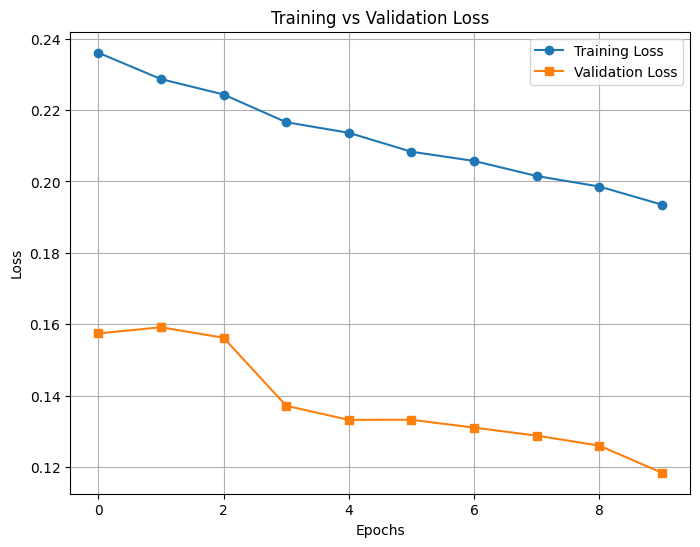

In [12]:
import matplotlib.pyplot as plt

def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    """
    Training driver function.
    Runs training and validation loops for a given number of epochs.
    Based on: Daniel Melchor,
    "A detailed guide to Pytorch's nn.Transformer() module."
    """
    
    # Lists to store loss values for plotting later
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        # Print epoch header
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        # Run one training epoch
        train_loss = train_loop(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]  # save training loss
        
        # Run validation epoch
        validation_loss = validation_loop(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]  # save validation loss
        
        # Print results for this epoch
        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss:.4f}")
        print()
        
    # Return recorded losses for further analysis/plotting
    return train_loss_list, validation_loss_list
    

# Run training + validation for 10 epochs
train_loss_list, validation_loss_list = fit(
    model, opt, loss_fn, train_dataloader, val_dataloader, 10
)



# Create a new figure
plt.figure(figsize=(8,6))

# Plot training and validation loss
plt.plot(train_loss_list, label="Training Loss", marker='o')
plt.plot(validation_loss_list, label="Validation Loss", marker='s')

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

# Grid + legend
plt.grid(True)
plt.legend()

# Save the figure
plt.savefig("loss_curve.png", dpi=300)

# Show the plot
plt.show()

In [11]:
def predict(model, input_sequence, max_length=15, SOS_token=2, EOS_token=3):
    """
    Greedy decoding for sequence generation using a trained Transformer.
    Starts with <SOS> and autoregressively generates tokens until <EOS> or max_length.
    Based on: Daniel Melchor,
    "A detailed guide to Pytorch's nn.Transformer() module."
    """
    model.eval()  # set model to evaluation mode
    
    # Decoder starts with SOS token
    y_input = torch.tensor([[SOS_token]], dtype=torch.long, device=device)

    # Get number of tokens in input (for reference)
    num_tokens = len(input_sequence[0])

    for _ in range(max_length):
        # Create causal mask for current target length
        tgt_mask = model.get_tgt_mask(y_input.size(1)).to(device)
        
        # Forward pass through the model
        pred = model(input_sequence, y_input, tgt_mask)
        
        # Get token with highest probability from last timestep
        next_item = pred.topk(1)[1].view(-1)[-1].item()
        next_item = torch.tensor([[next_item]], device=device)

        # Append predicted token to decoder input
        y_input = torch.cat((y_input, next_item), dim=1)

        # Stop if EOS is predicted
        if next_item.view(-1).item() == EOS_token:
            break

    # Return prediction as list of integers
    return y_input.view(-1).tolist()
  
  
# 🔹 Test the model on some toy examples
examples = [
    torch.tensor([[2, 0, 0, 0, 0, 0, 0, 0, 0, 3]], dtype=torch.long, device=device),   # mostly zeros
    torch.tensor([[2, 1, 1, 1, 1, 1, 1, 1, 1, 3]], dtype=torch.long, device=device),   # mostly ones
    torch.tensor([[2, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device),   # alternating start=1
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 3]], dtype=torch.long, device=device),   # alternating start=0
    torch.tensor([[2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3]], dtype=torch.long, device=device), # longer alternating
    torch.tensor([[2, 0, 1, 3]], dtype=torch.long, device=device)                      # short sequence
]

# Run prediction and print results
for idx, example in enumerate(examples):
    result = predict(model, example)
    print(f"Example {idx}")
    print(f"Input: {example.view(-1).tolist()[1:-1]}")       # exclude SOS/EOS from display
    print(f"Continuation: {result[1:-1]}")                   # exclude SOS/EOS from output
    print()


Example 0
Input: [0, 0, 0, 0, 0, 0, 0, 0]
Continuation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example 1
Input: [1, 1, 1, 1, 1, 1, 1, 1]
Continuation: [1, 1, 1, 1, 1, 1, 1, 1]

Example 2
Input: [1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 3
Input: [0, 1, 0, 1, 0, 1, 0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 4
Input: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

Example 5
Input: [0, 1]
Continuation: [0, 1, 0, 1, 0, 1, 0, 1, 0]

